In [31]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image

class Birds270Dataset(Dataset):
    def make_labels(self, csv_table):
        bird_str_labels = csv_table["labels"].unique()
        self.labels_str_to_int = {label:i  for i, label in enumerate(bird_str_labels)}
        self.labels_int_to_str = {i:label  for i, label in enumerate(bird_str_labels)}
        
    def __init__(self, dataset_dir, set_type="train", transform=None, selected_birds=None):
        csv_table = pd.read_csv(os.path.join(dataset_dir, "birds.csv"))
        if selected_birds != None:
            csv_table = csv_table[csv_table["labels"].isin(selected_birds)]
        self.img_data = csv_table[csv_table["data set"]==set_type]
        self.make_labels(self.img_data)
        self.dataset_dir = dataset_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        filepaths_col = self.img_data.columns.get_loc("filepaths")
        labels_col = self.img_data.columns.get_loc("labels")
        img_path = os.path.join(self.dataset_dir, self.img_data.iat[idx, filepaths_col])
        image = read_image(img_path).float()
        label = self.img_data.iat[idx, labels_col]
        if self.transform:
            image = self.transform(image)
        int_label = self.labels_str_to_int[label]
        return image, int_label
    
            
    

In [32]:
dataset_dir = "../data/birds270"
selected_birds = ["ALBATROSS", "BALD EAGLE", "BARN OWL", "EURASIAN MAGPIE", "FLAMINGO",
                  "MALLARD DUCK", "OSTRICH", "PEACOCK", "PELICAN", "TRUMPTER SWAN"]
tr = transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5)) # normalizes colors to range [-1,1]
train_dataset = Birds270Dataset(dataset_dir, set_type="train", selected_birds=selected_birds, transform=tr)
test_dataset = Birds270Dataset(dataset_dir, set_type="test", selected_birds=selected_birds, transform=tr)

In [33]:
from torch.utils.data import DataLoader

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [34]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(24 * 56 * 56, 100)
        self.output = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 24 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

    
net = Net()

In [35]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [39]:
import datetime

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    epoch_loss = 0
    start_time = datetime.datetime.now()
        
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        loss.backward()
        optimizer.step()

    time_elapsed = datetime.datetime.now() - start_time
    epoch_loss = running_loss / len(train_dataloader.dataset)
    # print statistics
    print(f"Epoch {epoch}:")
    print(f"\ttrain loss: {epoch_loss}")
    print(f"\tElapsed time: {time_elapsed}") 

print('Finished Training')

Epoch 0:
	train loss: 0.5748292116505891
	Elapsed time: 0:01:06.344595
Epoch 1:
	train loss: 0.27977477052812744
	Elapsed time: 0:01:05.475849
Finished Training


In [40]:
torch.save(net, '../model/simple_PW_model.pth')
torch.save(net.state_dict(), '../model/simple_PW_model_weights.pth')

In [41]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

In [42]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: %d %%' % (100 * correct / total))

Accuracy of the network: 70 %


In [43]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in selected_birds}
total_pred = {classname: 0 for classname in selected_birds}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[selected_birds[label]] += 1
            total_pred[selected_birds[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class ALBATROSS is: 0.0 %
Accuracy for class BALD EAGLE is: 100.0 %
Accuracy for class BARN OWL is: 80.0 %
Accuracy for class EURASIAN MAGPIE is: 100.0 %
Accuracy for class FLAMINGO is: 80.0 %
Accuracy for class MALLARD DUCK is: 60.0 %
Accuracy for class OSTRICH is: 60.0 %
Accuracy for class PEACOCK is: 80.0 %
Accuracy for class PELICAN is: 60.0 %
Accuracy for class TRUMPTER SWAN is: 80.0 %


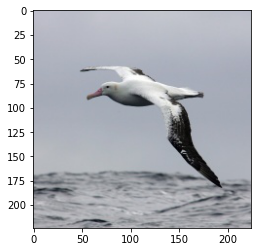

Label (number): 0, (name): ALBATROSS
[('TRUMPTER SWAN', 0.4551525115966797), ('PELICAN', 0.3758355379104614), ('ALBATROSS', 0.10582033544778824), ('BALD EAGLE', 0.031515903770923615), ('MALLARD DUCK', 0.026398412883281708), ('BARN OWL', 0.003898616647347808), ('FLAMINGO', 0.0010708658955991268), ('OSTRICH', 0.00021353541524149477), ('EURASIAN MAGPIE', 9.338837116956711e-05), ('PEACOCK', 8.327945693054062e-07)]


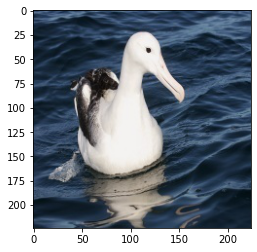

Label (number): 0, (name): ALBATROSS
[('PELICAN', 0.7106461524963379), ('BALD EAGLE', 0.1910862773656845), ('ALBATROSS', 0.08962918072938919), ('TRUMPTER SWAN', 0.006644677370786667), ('MALLARD DUCK', 0.0016273749060928822), ('FLAMINGO', 0.0003130714176222682), ('BARN OWL', 3.8398611650336534e-05), ('EURASIAN MAGPIE', 1.0706664397730492e-05), ('PEACOCK', 2.980019644382992e-06), ('OSTRICH', 1.1938457191718044e-06)]


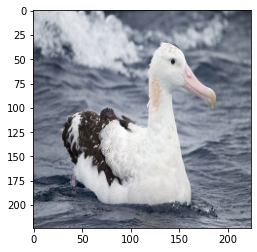

Label (number): 0, (name): ALBATROSS
[('PELICAN', 0.48892542719841003), ('ALBATROSS', 0.3422030210494995), ('BALD EAGLE', 0.11660889536142349), ('TRUMPTER SWAN', 0.048647232353687286), ('MALLARD DUCK', 0.0035085070412606), ('BARN OWL', 8.774375601205975e-05), ('FLAMINGO', 1.3152912288205698e-05), ('EURASIAN MAGPIE', 4.347188678366365e-06), ('OSTRICH', 1.5774155599501682e-06), ('PEACOCK', 1.4502363754331782e-09)]


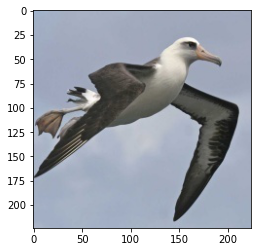

Label (number): 0, (name): ALBATROSS
[('MALLARD DUCK', 0.9058963060379028), ('ALBATROSS', 0.03743330016732216), ('TRUMPTER SWAN', 0.022485870867967606), ('EURASIAN MAGPIE', 0.014007538557052612), ('BALD EAGLE', 0.009520185180008411), ('PELICAN', 0.009193146601319313), ('OSTRICH', 0.0008616455597802997), ('BARN OWL', 0.0005532958311960101), ('FLAMINGO', 3.8517810025950894e-05), ('PEACOCK', 1.0106826266564894e-05)]


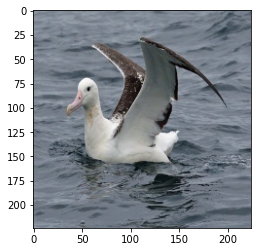

Label (number): 0, (name): ALBATROSS
[('PELICAN', 0.910668671131134), ('TRUMPTER SWAN', 0.06715129315853119), ('BALD EAGLE', 0.013302543200552464), ('ALBATROSS', 0.008635375648736954), ('MALLARD DUCK', 0.0001152159456978552), ('EURASIAN MAGPIE', 0.00010832231055246666), ('FLAMINGO', 1.0519297575228848e-05), ('PEACOCK', 4.478685696085449e-06), ('BARN OWL', 3.0528995011991356e-06), ('OSTRICH', 5.302705403664731e-07)]


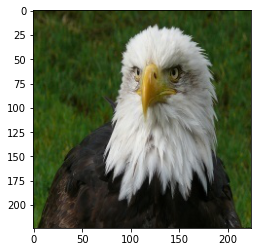

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9998205304145813), ('BARN OWL', 0.00017385967657901347), ('PELICAN', 5.156644419912482e-06), ('ALBATROSS', 3.417354434986919e-07), ('TRUMPTER SWAN', 1.169290229086073e-07), ('PEACOCK', 8.537704765387844e-09), ('OSTRICH', 3.673814141791354e-09), ('FLAMINGO', 2.7959676796029953e-09), ('MALLARD DUCK', 1.4434413664332624e-09), ('EURASIAN MAGPIE', 3.6659236757330405e-10)]


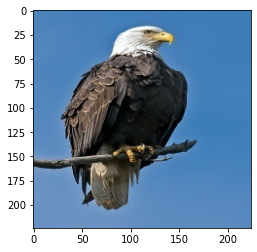

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9998782873153687), ('PELICAN', 7.35964349587448e-05), ('EURASIAN MAGPIE', 2.78501320281066e-05), ('MALLARD DUCK', 1.3089256754028611e-05), ('OSTRICH', 4.33418199463631e-06), ('ALBATROSS', 1.5854344610488624e-06), ('PEACOCK', 1.183957351713616e-06), ('FLAMINGO', 5.338055775183648e-09), ('TRUMPTER SWAN', 4.297830535904268e-09), ('BARN OWL', 3.6349854237727186e-09)]


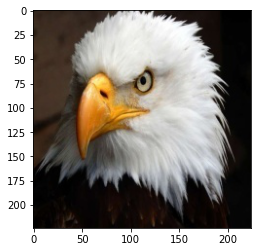

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9988068342208862), ('BARN OWL', 0.0011931969784200191), ('ALBATROSS', 9.366679654121413e-10), ('FLAMINGO', 8.369550608122722e-10), ('PELICAN', 1.34159128251099e-10), ('OSTRICH', 3.0118199600970286e-12), ('TRUMPTER SWAN', 3.2617739889259645e-13), ('PEACOCK', 1.8258266806011475e-13), ('MALLARD DUCK', 7.133598318173964e-14), ('EURASIAN MAGPIE', 3.996244214587158e-19)]


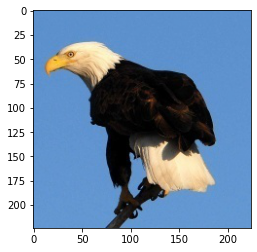

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9999258518218994), ('OSTRICH', 4.389842797536403e-05), ('EURASIAN MAGPIE', 2.6398089175927453e-05), ('MALLARD DUCK', 3.2670036489435006e-06), ('PELICAN', 3.489163304948306e-07), ('PEACOCK', 2.8891165015920706e-07), ('ALBATROSS', 1.5430900646151713e-07), ('TRUMPTER SWAN', 5.179230821994452e-09), ('BARN OWL', 4.2254622023563115e-10), ('FLAMINGO', 2.6203721484319153e-11)]


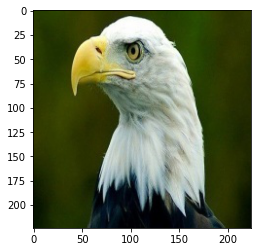

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9999517202377319), ('BARN OWL', 4.790267121279612e-05), ('ALBATROSS', 9.938464984315942e-08), ('PELICAN', 9.309721349382016e-08), ('TRUMPTER SWAN', 7.578096017368807e-08), ('PEACOCK', 4.515515072966991e-09), ('FLAMINGO', 6.867851842784489e-10), ('OSTRICH', 1.8083673447577553e-10), ('MALLARD DUCK', 1.6518028611578472e-10), ('EURASIAN MAGPIE', 7.511707185089977e-13)]


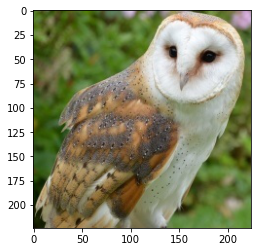

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.9923598170280457), ('ALBATROSS', 0.004847716074436903), ('BALD EAGLE', 0.002561028813943267), ('FLAMINGO', 7.677478424739093e-05), ('PELICAN', 5.966837125015445e-05), ('OSTRICH', 3.82195612473879e-05), ('MALLARD DUCK', 3.585981176001951e-05), ('PEACOCK', 1.2306467397138476e-05), ('TRUMPTER SWAN', 8.213620276364964e-06), ('EURASIAN MAGPIE', 4.962320758750138e-07)]


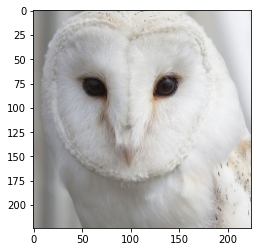

Label (number): 2, (name): BARN OWL
[('PELICAN', 0.6253206729888916), ('TRUMPTER SWAN', 0.2807752192020416), ('BALD EAGLE', 0.038620926439762115), ('ALBATROSS', 0.027642561122775078), ('BARN OWL', 0.020912514999508858), ('MALLARD DUCK', 0.006009877193719149), ('FLAMINGO', 0.00045064129517413676), ('OSTRICH', 0.00019409316882956773), ('EURASIAN MAGPIE', 7.34891218598932e-05), ('PEACOCK', 7.295661852424473e-10)]


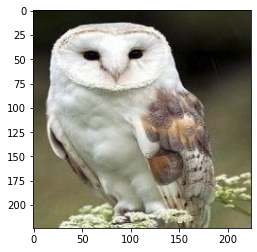

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.9978806972503662), ('BALD EAGLE', 0.001682872069068253), ('FLAMINGO', 0.00026906724087893963), ('TRUMPTER SWAN', 0.00011244033521506935), ('PELICAN', 4.187455851933919e-05), ('ALBATROSS', 6.003372163831955e-06), ('OSTRICH', 4.596716280502733e-06), ('PEACOCK', 2.4045491500146454e-06), ('MALLARD DUCK', 5.186480134256044e-10), ('EURASIAN MAGPIE', 6.517620471102603e-11)]


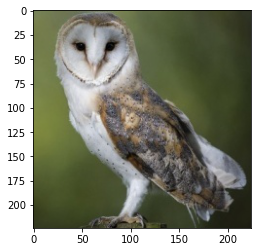

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.9260073304176331), ('BALD EAGLE', 0.06881321966648102), ('ALBATROSS', 0.0035759061574935913), ('TRUMPTER SWAN', 0.000796750420704484), ('PELICAN', 0.0005408385768532753), ('PEACOCK', 0.00010845166252693161), ('FLAMINGO', 7.175392238423228e-05), ('OSTRICH', 5.63872599741444e-05), ('MALLARD DUCK', 2.2326139514916576e-05), ('EURASIAN MAGPIE', 7.0806959229230415e-06)]


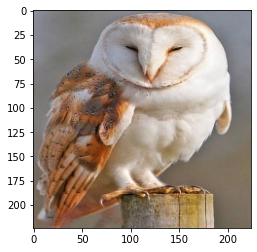

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.8893691301345825), ('PELICAN', 0.06853999942541122), ('ALBATROSS', 0.019783716648817062), ('BALD EAGLE', 0.014654703438282013), ('TRUMPTER SWAN', 0.0035509055014699697), ('MALLARD DUCK', 0.0034999437630176544), ('OSTRICH', 0.000435223919339478), ('FLAMINGO', 0.00014650510274805129), ('EURASIAN MAGPIE', 1.9265069568064064e-05), ('PEACOCK', 4.982712198398076e-07)]


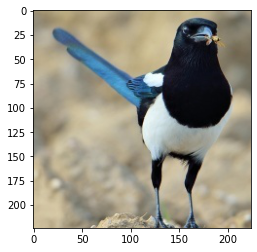

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.999503493309021), ('BALD EAGLE', 0.0003015269758179784), ('PELICAN', 0.00010433827992528677), ('OSTRICH', 8.81314481375739e-05), ('MALLARD DUCK', 1.2315716730881832e-06), ('PEACOCK', 6.414732069970341e-07), ('TRUMPTER SWAN', 6.18360104454041e-07), ('BARN OWL', 9.245449916761572e-08), ('ALBATROSS', 1.508789004844857e-08), ('FLAMINGO', 1.4303717064956256e-11)]


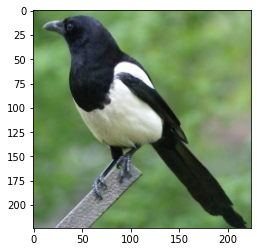

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.9559004902839661), ('PELICAN', 0.03526562079787254), ('BALD EAGLE', 0.00823119841516018), ('OSTRICH', 0.0002778476045932621), ('MALLARD DUCK', 0.00020340272749308497), ('TRUMPTER SWAN', 8.484709542244673e-05), ('ALBATROSS', 1.956702908501029e-05), ('PEACOCK', 1.369276378682116e-05), ('BARN OWL', 3.2753032428445294e-06), ('FLAMINGO', 8.359361203247317e-08)]


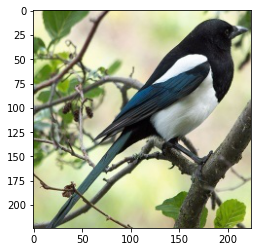

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.9846768975257874), ('BALD EAGLE', 0.010264340788125992), ('PELICAN', 0.002453070366755128), ('PEACOCK', 0.002181083895266056), ('OSTRICH', 0.0002771831932477653), ('ALBATROSS', 0.00011675029236357659), ('MALLARD DUCK', 1.3127144484315068e-05), ('BARN OWL', 9.194329322781414e-06), ('TRUMPTER SWAN', 8.344192792719696e-06), ('FLAMINGO', 3.6885743348591404e-09)]


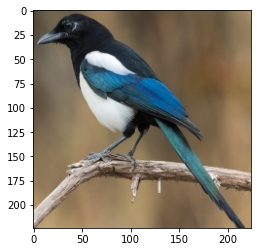

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.9771136045455933), ('PEACOCK', 0.01966080628335476), ('BALD EAGLE', 0.0017419978976249695), ('OSTRICH', 0.0011760543566197157), ('PELICAN', 0.00028397617279551923), ('BARN OWL', 1.0010460755438544e-05), ('MALLARD DUCK', 9.495002814219333e-06), ('TRUMPTER SWAN', 3.7101813177287113e-06), ('ALBATROSS', 2.9105038379384496e-07), ('FLAMINGO', 6.3280483075800475e-09)]


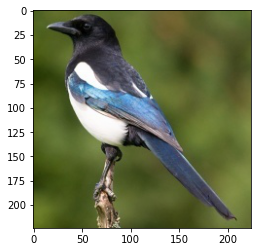

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.39113327860832214), ('PEACOCK', 0.35052335262298584), ('TRUMPTER SWAN', 0.13574586808681488), ('PELICAN', 0.07606041431427002), ('ALBATROSS', 0.017495159059762955), ('MALLARD DUCK', 0.011282538063824177), ('BALD EAGLE', 0.010150215588510036), ('BARN OWL', 0.007343001198023558), ('FLAMINGO', 0.00016066088574007154), ('OSTRICH', 0.00010550339356996119)]


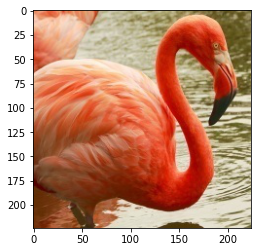

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9843834638595581), ('BARN OWL', 0.01561648864299059), ('OSTRICH', 1.2474817012719797e-10), ('MALLARD DUCK', 1.4114744095738985e-11), ('BALD EAGLE', 2.9716794346448805e-13), ('PEACOCK', 2.679010984406316e-13), ('PELICAN', 1.9376998107185212e-13), ('ALBATROSS', 8.852218003757573e-14), ('EURASIAN MAGPIE', 5.81057157190937e-20), ('TRUMPTER SWAN', 2.8352998973472027e-31)]


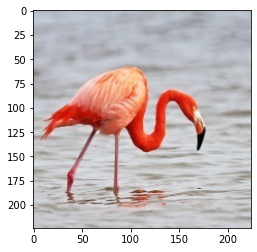

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.8523637056350708), ('PELICAN', 0.11210447549819946), ('OSTRICH', 0.03529391437768936), ('BARN OWL', 0.00022396304120775312), ('BALD EAGLE', 8.967085705080535e-06), ('MALLARD DUCK', 4.409670964378165e-06), ('EURASIAN MAGPIE', 5.636982223222731e-07), ('ALBATROSS', 1.1439573199822917e-07), ('PEACOCK', 2.7854551998274246e-10), ('TRUMPTER SWAN', 1.3495237913274671e-11)]


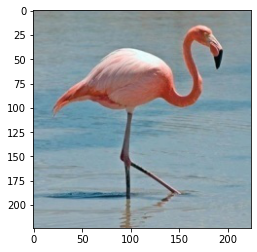

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.7308460474014282), ('PELICAN', 0.21708084642887115), ('BALD EAGLE', 0.050365373492240906), ('OSTRICH', 0.0007057500188238919), ('BARN OWL', 0.000598655897192657), ('ALBATROSS', 0.00028972997097298503), ('TRUMPTER SWAN', 0.00011015225027222186), ('MALLARD DUCK', 2.8934530291735427e-06), ('PEACOCK', 4.446772834398871e-07), ('EURASIAN MAGPIE', 7.016397773895733e-08)]


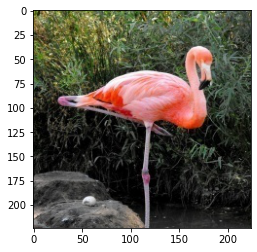

Label (number): 4, (name): FLAMINGO
[('PELICAN', 0.6192122101783752), ('FLAMINGO', 0.3697911500930786), ('ALBATROSS', 0.008548534475266933), ('BARN OWL', 0.0012273808242753148), ('OSTRICH', 0.0009989794343709946), ('BALD EAGLE', 0.00011569839989533648), ('MALLARD DUCK', 0.00010539795039221644), ('EURASIAN MAGPIE', 5.07656068293727e-07), ('TRUMPTER SWAN', 8.641364956929465e-08), ('PEACOCK', 5.931944935255729e-10)]


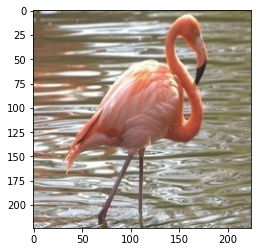

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.7119210362434387), ('PELICAN', 0.28525957465171814), ('OSTRICH', 0.0017606338951736689), ('BARN OWL', 0.0007730486104264855), ('BALD EAGLE', 0.0001863951765699312), ('ALBATROSS', 7.370121602434665e-05), ('MALLARD DUCK', 1.7754133295966312e-05), ('PEACOCK', 5.372413397708442e-06), ('EURASIAN MAGPIE', 1.6791930192994187e-06), ('TRUMPTER SWAN', 8.934139827943e-07)]


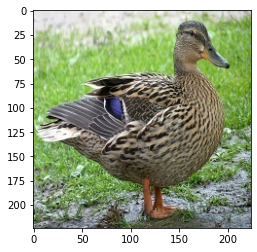

Label (number): 5, (name): MALLARD DUCK
[('BALD EAGLE', 0.6364027261734009), ('MALLARD DUCK', 0.26939907670021057), ('PEACOCK', 0.0697803720831871), ('OSTRICH', 0.012427588924765587), ('BARN OWL', 0.004728310275822878), ('EURASIAN MAGPIE', 0.004342870321124792), ('PELICAN', 0.0028583931270986795), ('ALBATROSS', 4.753316898131743e-05), ('FLAMINGO', 1.2692706150119193e-05), ('TRUMPTER SWAN', 4.293448512271425e-07)]


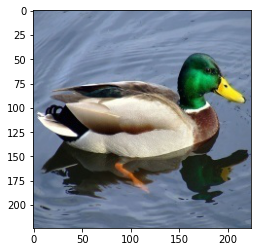

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.7505894303321838), ('ALBATROSS', 0.20940998196601868), ('PELICAN', 0.029519861564040184), ('BALD EAGLE', 0.006087052170187235), ('EURASIAN MAGPIE', 0.004204755183309317), ('TRUMPTER SWAN', 0.00014951699995435774), ('BARN OWL', 3.204002132406458e-05), ('FLAMINGO', 5.001669705961831e-06), ('OSTRICH', 2.191528665207443e-06), ('PEACOCK', 1.9626563130259456e-07)]


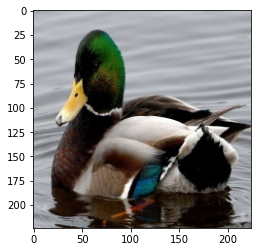

Label (number): 5, (name): MALLARD DUCK
[('BALD EAGLE', 0.9975365400314331), ('MALLARD DUCK', 0.0023661209270358086), ('PELICAN', 2.5788456696318462e-05), ('ALBATROSS', 2.107046020682901e-05), ('EURASIAN MAGPIE', 2.0406672774697654e-05), ('OSTRICH', 1.6100664652185515e-05), ('BARN OWL', 1.4048808225197718e-05), ('PEACOCK', 7.844341176621583e-09), ('TRUMPTER SWAN', 3.3702460822127023e-09), ('FLAMINGO', 3.15583836840716e-10)]


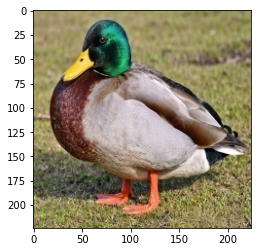

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.9999209642410278), ('EURASIAN MAGPIE', 2.9630247809109278e-05), ('BALD EAGLE', 2.8852973628090695e-05), ('PELICAN', 1.9216760847484693e-05), ('BARN OWL', 6.829364451732545e-07), ('ALBATROSS', 2.513533274850488e-07), ('OSTRICH', 1.9208165724649007e-07), ('TRUMPTER SWAN', 1.6890199106001091e-07), ('FLAMINGO', 1.4253463298530278e-08), ('PEACOCK', 1.8992820649543773e-09)]


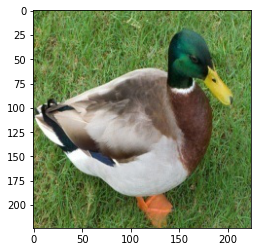

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.9931437969207764), ('BALD EAGLE', 0.00297451950609684), ('ALBATROSS', 0.001234484720043838), ('TRUMPTER SWAN', 0.0011557406978681684), ('BARN OWL', 0.0007638713577762246), ('PELICAN', 0.0005132355145178735), ('EURASIAN MAGPIE', 0.00015969242667779326), ('FLAMINGO', 3.0455083106062375e-05), ('OSTRICH', 2.3726519430056214e-05), ('PEACOCK', 5.05386708482547e-07)]


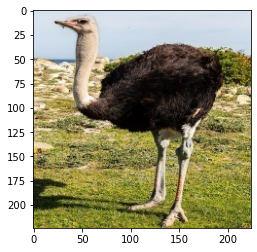

Label (number): 6, (name): OSTRICH
[('OSTRICH', 0.9854788780212402), ('BALD EAGLE', 0.013960417360067368), ('EURASIAN MAGPIE', 0.0005187774659134448), ('BARN OWL', 3.6497505789157e-05), ('ALBATROSS', 1.904391979223874e-06), ('PEACOCK', 1.6913204490265343e-06), ('MALLARD DUCK', 1.1994939086434897e-06), ('PELICAN', 7.1340639351547e-07), ('TRUMPTER SWAN', 2.900041096154382e-09), ('FLAMINGO', 4.0822279584462606e-11)]


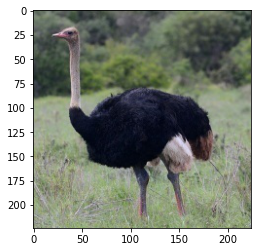

Label (number): 6, (name): OSTRICH
[('BALD EAGLE', 0.9549952745437622), ('EURASIAN MAGPIE', 0.02382279746234417), ('OSTRICH', 0.020499777048826218), ('PEACOCK', 0.00040777772665023804), ('PELICAN', 0.00027197448071092367), ('MALLARD DUCK', 1.1202620271433261e-06), ('BARN OWL', 6.923924615875876e-07), ('ALBATROSS', 2.483664616192982e-07), ('TRUMPTER SWAN', 2.2503488139591354e-07), ('FLAMINGO', 2.9901598974646504e-09)]


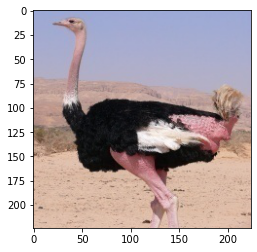

Label (number): 6, (name): OSTRICH
[('OSTRICH', 0.6914374232292175), ('BALD EAGLE', 0.29914939403533936), ('EURASIAN MAGPIE', 0.008275311440229416), ('MALLARD DUCK', 0.0003364846343174577), ('BARN OWL', 0.00031945633236318827), ('PELICAN', 0.00025808694772422314), ('PEACOCK', 0.00022022757912054658), ('ALBATROSS', 3.444782578299055e-06), ('FLAMINGO', 1.2436824192718632e-07), ('TRUMPTER SWAN', 2.8471944801822247e-09)]


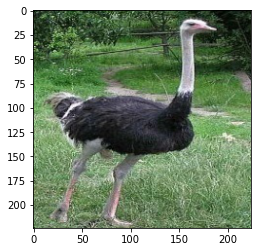

Label (number): 6, (name): OSTRICH
[('BALD EAGLE', 0.7014880776405334), ('OSTRICH', 0.21779094636440277), ('PEACOCK', 0.051142673939466476), ('PELICAN', 0.01916535757482052), ('TRUMPTER SWAN', 0.007371195591986179), ('EURASIAN MAGPIE', 0.0021115143317729235), ('ALBATROSS', 0.0004093491879757494), ('BARN OWL', 0.00032489479053765535), ('FLAMINGO', 0.0001788729423424229), ('MALLARD DUCK', 1.718083512969315e-05)]


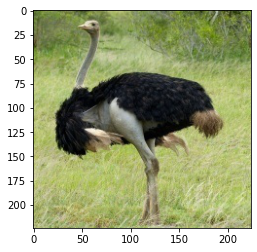

Label (number): 6, (name): OSTRICH
[('OSTRICH', 0.9942527413368225), ('EURASIAN MAGPIE', 0.003639539936557412), ('BALD EAGLE', 0.002100608544424176), ('MALLARD DUCK', 5.23453581990907e-06), ('BARN OWL', 1.732565920065099e-06), ('PEACOCK', 1.0501364045012451e-07), ('PELICAN', 9.889360441661665e-09), ('ALBATROSS', 6.227485749299433e-10), ('TRUMPTER SWAN', 6.469692837018926e-11), ('FLAMINGO', 6.349299992020052e-12)]


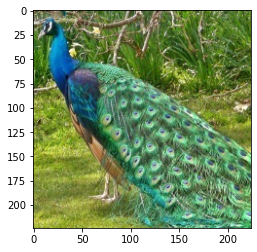

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.999660849571228), ('EURASIAN MAGPIE', 0.00021575916616711766), ('BALD EAGLE', 0.00011024997365893796), ('PELICAN', 1.2999538739677519e-05), ('OSTRICH', 8.506179938194691e-08), ('TRUMPTER SWAN', 2.8481426994630965e-08), ('ALBATROSS', 2.8264798501709265e-08), ('BARN OWL', 4.846099521671476e-09), ('MALLARD DUCK', 1.1969243651765993e-10), ('FLAMINGO', 3.332776979739216e-12)]


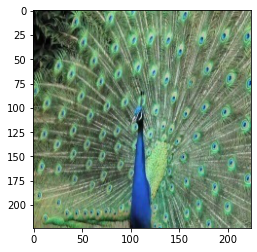

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.9834603667259216), ('PELICAN', 0.012730727903544903), ('TRUMPTER SWAN', 0.0026461235247552395), ('BALD EAGLE', 0.001036452711559832), ('BARN OWL', 5.235785283730365e-05), ('EURASIAN MAGPIE', 3.3376792998751625e-05), ('FLAMINGO', 1.8636323147802614e-05), ('ALBATROSS', 1.6503119695698842e-05), ('OSTRICH', 5.10725294589065e-06), ('MALLARD DUCK', 3.8994562601146754e-07)]


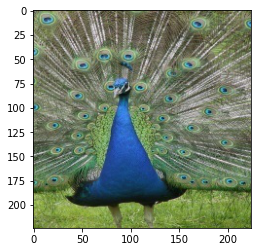

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.999146580696106), ('EURASIAN MAGPIE', 0.00045149383367970586), ('TRUMPTER SWAN', 0.000211642385693267), ('PELICAN', 0.0001327871868852526), ('BALD EAGLE', 2.0458253857214004e-05), ('MALLARD DUCK', 1.765223714755848e-05), ('BARN OWL', 1.5142725715122651e-05), ('ALBATROSS', 3.1583558666170575e-06), ('OSTRICH', 6.390463909156097e-07), ('FLAMINGO', 3.7375309602794005e-07)]


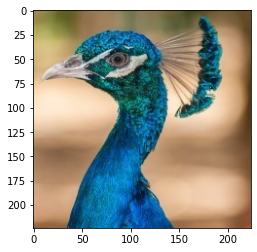

Label (number): 7, (name): PEACOCK
[('EURASIAN MAGPIE', 0.9088476300239563), ('PEACOCK', 0.09114989638328552), ('BALD EAGLE', 1.104155899156467e-06), ('PELICAN', 7.587132131448016e-07), ('MALLARD DUCK', 3.805844812632131e-07), ('TRUMPTER SWAN', 1.0785601745055828e-07), ('ALBATROSS', 3.8635796784092236e-08), ('OSTRICH', 1.706017549452099e-08), ('BARN OWL', 1.0844334319415339e-08), ('FLAMINGO', 1.949242498097345e-13)]


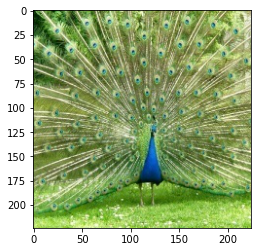

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.9989452958106995), ('BARN OWL', 0.0006254599429666996), ('PELICAN', 0.00024801568360999227), ('BALD EAGLE', 8.319027256220579e-05), ('MALLARD DUCK', 7.99808040028438e-05), ('EURASIAN MAGPIE', 7.300619472516701e-06), ('TRUMPTER SWAN', 7.245083907037042e-06), ('FLAMINGO', 2.023001798079349e-06), ('OSTRICH', 1.4182553513819585e-06), ('ALBATROSS', 1.2254228920483e-07)]


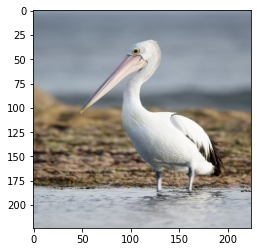

Label (number): 8, (name): PELICAN
[('PELICAN', 0.8289089798927307), ('TRUMPTER SWAN', 0.11572329699993134), ('ALBATROSS', 0.02714761160314083), ('BARN OWL', 0.023783691227436066), ('BALD EAGLE', 0.002875301521271467), ('EURASIAN MAGPIE', 0.000696993840392679), ('MALLARD DUCK', 0.0005540729616768658), ('FLAMINGO', 0.00017956689407583326), ('OSTRICH', 6.770488107576966e-05), ('PEACOCK', 6.279648368945345e-05)]


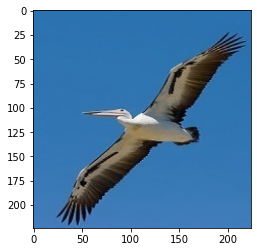

Label (number): 8, (name): PELICAN
[('PELICAN', 0.8855699300765991), ('BALD EAGLE', 0.08606734126806259), ('ALBATROSS', 0.02228895016014576), ('TRUMPTER SWAN', 0.00405904371291399), ('MALLARD DUCK', 0.0009804771980270743), ('EURASIAN MAGPIE', 0.00044291961239650846), ('FLAMINGO', 0.00040189881110563874), ('PEACOCK', 0.00012465000327210873), ('BARN OWL', 3.309347448521294e-05), ('OSTRICH', 3.167289833072573e-05)]


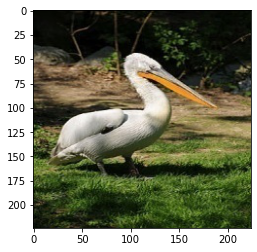

Label (number): 8, (name): PELICAN
[('BALD EAGLE', 0.5382983684539795), ('BARN OWL', 0.4601353406906128), ('PELICAN', 0.0011384033132344484), ('FLAMINGO', 0.00018810428446158767), ('PEACOCK', 0.00012065816554240882), ('TRUMPTER SWAN', 0.00011177012493135408), ('ALBATROSS', 5.491830961545929e-06), ('MALLARD DUCK', 1.5280136267392663e-06), ('OSTRICH', 2.852137868103455e-07), ('EURASIAN MAGPIE', 4.299093969706291e-09)]


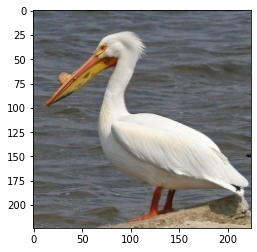

Label (number): 8, (name): PELICAN
[('PELICAN', 0.9904248118400574), ('TRUMPTER SWAN', 0.005426507908850908), ('BALD EAGLE', 0.002541690832003951), ('MALLARD DUCK', 0.0012948081130161881), ('ALBATROSS', 0.00019928919209633023), ('FLAMINGO', 7.244353764690459e-05), ('EURASIAN MAGPIE', 2.5985778847825713e-05), ('BARN OWL', 1.0779740478028543e-05), ('OSTRICH', 3.6385042676556623e-06), ('PEACOCK', 1.7721570877426984e-09)]


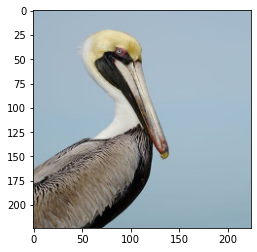

Label (number): 8, (name): PELICAN
[('TRUMPTER SWAN', 0.6739494800567627), ('PELICAN', 0.15589824318885803), ('ALBATROSS', 0.08155839145183563), ('MALLARD DUCK', 0.07878224551677704), ('BARN OWL', 0.005098617170006037), ('BALD EAGLE', 0.0032239267602562904), ('EURASIAN MAGPIE', 0.0005855427007190883), ('FLAMINGO', 0.0005805074470117688), ('OSTRICH', 0.0003226936387363821), ('PEACOCK', 3.2910887171055947e-07)]


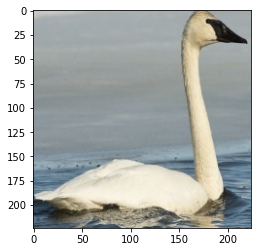

Label (number): 9, (name): TRUMPTER SWAN
[('TRUMPTER SWAN', 0.997623860836029), ('PELICAN', 0.0013005872024223208), ('ALBATROSS', 0.0008238496957346797), ('BALD EAGLE', 0.00011097607057308778), ('BARN OWL', 8.685096690896899e-05), ('MALLARD DUCK', 2.1787975128972903e-05), ('OSTRICH', 1.7789527191780508e-05), ('FLAMINGO', 1.3862784726370592e-05), ('EURASIAN MAGPIE', 3.4505470125623106e-07), ('PEACOCK', 2.0256127886142394e-09)]


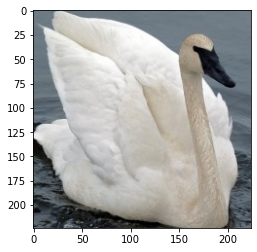

Label (number): 9, (name): TRUMPTER SWAN
[('BALD EAGLE', 0.39682307839393616), ('TRUMPTER SWAN', 0.35807284712791443), ('BARN OWL', 0.2343401312828064), ('ALBATROSS', 0.005040362011641264), ('PELICAN', 0.004170489497482777), ('FLAMINGO', 0.0014847671845927835), ('OSTRICH', 4.572469333652407e-05), ('MALLARD DUCK', 2.2608935978496447e-05), ('EURASIAN MAGPIE', 1.164589225055579e-08), ('PEACOCK', 7.568253662659785e-11)]


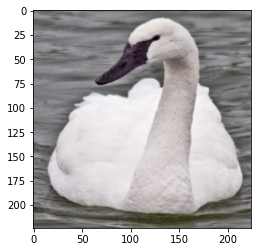

Label (number): 9, (name): TRUMPTER SWAN
[('TRUMPTER SWAN', 0.9996824264526367), ('PELICAN', 0.00021275503968354315), ('BALD EAGLE', 9.210699499817565e-05), ('ALBATROSS', 1.0863454917853232e-05), ('MALLARD DUCK', 1.8482944597053574e-06), ('BARN OWL', 3.3509518715391096e-08), ('FLAMINGO', 6.02895555701366e-09), ('EURASIAN MAGPIE', 4.532209718632885e-09), ('OSTRICH', 1.3870365966894838e-09), ('PEACOCK', 1.8871584050767116e-14)]


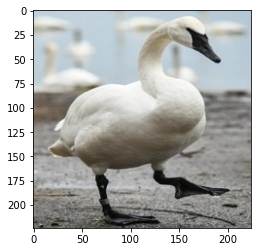

Label (number): 9, (name): TRUMPTER SWAN
[('TRUMPTER SWAN', 0.41398999094963074), ('ALBATROSS', 0.3503355383872986), ('BARN OWL', 0.19406989216804504), ('PELICAN', 0.031757596880197525), ('BALD EAGLE', 0.008612080477178097), ('FLAMINGO', 0.0007389415404759347), ('MALLARD DUCK', 0.00042941022547893226), ('OSTRICH', 5.808194327983074e-05), ('EURASIAN MAGPIE', 8.516110028722323e-06), ('PEACOCK', 3.2756183543369843e-08)]


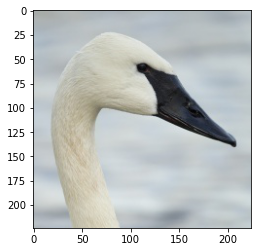

Label (number): 9, (name): TRUMPTER SWAN
[('TRUMPTER SWAN', 0.7147153615951538), ('MALLARD DUCK', 0.17311136424541473), ('PELICAN', 0.06131654605269432), ('BALD EAGLE', 0.028334608301520348), ('ALBATROSS', 0.012703662738204002), ('OSTRICH', 0.004249583464115858), ('BARN OWL', 0.0028855663258582354), ('EURASIAN MAGPIE', 0.0024345875717699528), ('FLAMINGO', 0.00024832732742652297), ('PEACOCK', 3.3429381574023864e-07)]


In [44]:
#function for displaying a picture
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

display_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for data in display_dataloader:
    images, labels = data
    # calculate outputs by running images through the network
    outputs = net(images)
    img = images[0].squeeze()
    label = labels[0].item()
    imshow(img)
    label_str = test_dataset.labels_int_to_str[label]
    print(f"Label (number): {label}, (name): {label_str}")
    prob_tensor = nn.Softmax(dim=1)(outputs.data).squeeze()
    prob_list = prob_tensor.tolist()
    prob_labels = [(test_dataset.labels_int_to_str[i], prob) for i, prob in enumerate(prob_list)]
    prob_labels.sort(key = lambda t : t[1], reverse=True)
    
    print(prob_labels)
